In [1]:
%matplotlib notebook

from matplotlib import rcParams
# Set the font of the plots:
rcParams['font.family'] = 'Helvetica'
rcParams['font.sans-serif'] = ['Helvetica']

import matplotlib.pyplot as plt
import networkx as nx
import toverboom
import toverboom.lineageGraph
import toverboom.optimizeLayout
import toverboom.preprocessing

# Development:
import importlib
importlib.reload(toverboom)
importlib.reload(toverboom.lineageGraph)
importlib.reload(toverboom.preprocessing)
importlib.reload(toverboom.optimizeLayout)

<module 'toverboom.optimizeLayout' from '/media/sf_internalTools/toverBoom/toverboom/optimizeLayout.py'>

In [154]:
# Load the graph file into a networkx graph
graph = nx.read_graphml(f'../nla-organoids/tables/APKS1_CNV_tree.graphml')
graph = toverboom.preprocessing.convertFromStringKeys(graph)

<IPython.core.display.Javascript object>


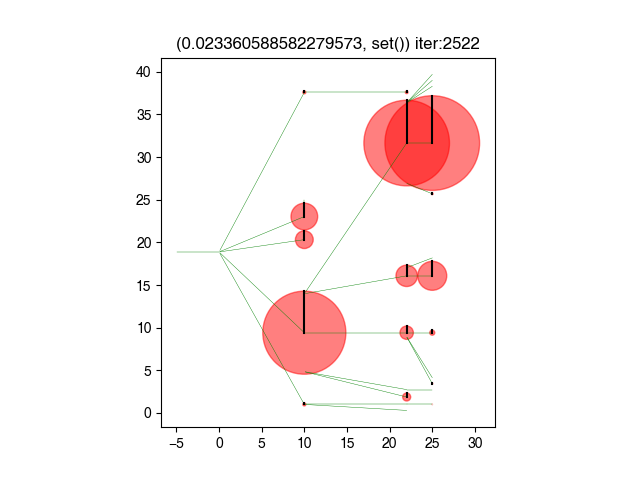

[35, 8, 30, 17, 9, 36, 2, 5, 24, 0, 4, 1, 19, 20, 3, 12, 34, 29, 23]

In [155]:
# Instantiate the lineage graph object
lg = toverboom.lineageGraph.LineageGraph(graph)

# Create a figure for our plot:
fig, ax = plt.subplots()

# Find the best layout
toverboom.optimizeLayout.optimize_layout(lg,visualize_progress_ax=ax, visualize_progress_fig=fig)

<IPython.core.display.Javascript object>


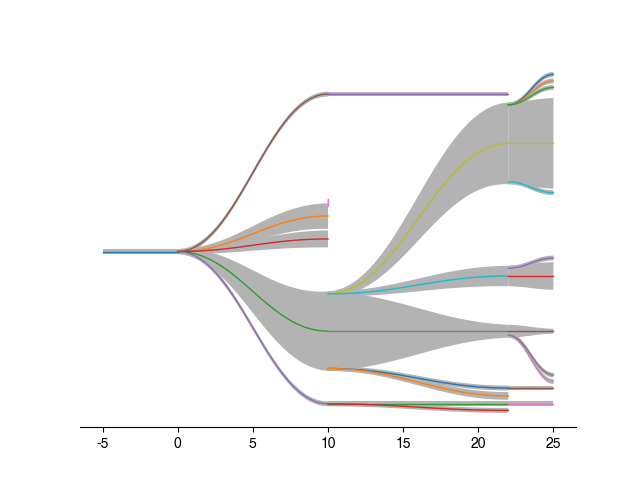

In [156]:
# Plot the polygons of the tree
fig, ax = plt.subplots()

wavyness=0.4
lg.xDistance=10
lg.verticalSpacing = 0.2

lg.plotEdges(ax, bezier=True,wavyness=wavyness,stepCount=30,plotArgs={'lw':1}, offsetCentroid=True)
lg.plotPatches(ax=ax,wavyness=wavyness)

# Remove plot spines:
toverboom.lineageGraph.despine(ax)
# Scale labels to plot size:
toverboom.lineageGraph.format_x_axis_labels(ax)

fig.canvas.draw()

## Plot single cells on top of the tree

First construct a matrix where the single cells are described
Required columns are:
```
tp : timepoint where the cell was measured
cluster: to what cluster/clone does the cell belong
```
Optional columns are:
```
size : plotted size of the cell
marker : marker 
color  : color of the marker
```

In [157]:
# Load example data:
replicate = 'APKS1'
cellBarcodes = pd.read_pickle('/media/sf_projects/nla-organoids/tables/cellToBarcode.pickle').loc[replicate]
cellCnv = pd.read_pickle('/media/sf_projects/nla-organoids/tables/singleCellCNVClustering.pickle.gz').loc[replicate]
cellData = cellCnv

#### Contruct a dataframe with cell data

# Assing colors:
cellData['color'] = [{
    3:'r', 16:'r', 20:'r' ,
    5:'c',  21:'c',
    2:'orange'}.get(cluster,'grey') for cluster in cellData['cluster'] ]

# Assign passage:
cellData['tp'] = [passage for passage, plate, cell in list(cellData.index)]

# Assign sizes
cellData['size'] = [40 if cluster==2 else 20 for cluster in cellData['cluster'] ]

# Assign markers
cellData['marker'] = [{3:'+', 5:'+', 1:'*'}.get(cluster,'.') for cluster in cellData['cluster'] ]

cellData.head()

cluster   color  tp  size marker
10 1-1 6         1    grey  10    20      *
       62        8    grey  10    20      .
       68        2  orange  10    40      .
       83        2  orange  10    40      .
       88        2  orange  10    40      .

<IPython.core.display.Javascript object>


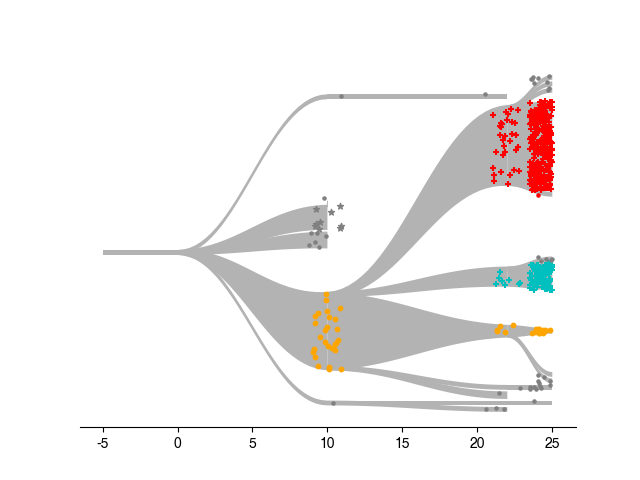

In [158]:
lg.plotSingleCells(cellData)